In [38]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

(1000,)


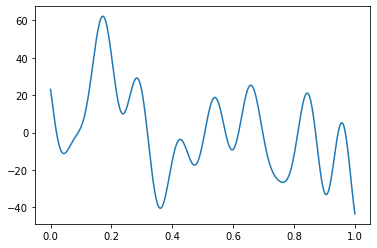

In [12]:
N = 1000 # size of output vector
x = np.linspace(0,1,N) # x-values to plot
def generate_pot():
    # N is size of output vector
    rand = lambda : np.random.randint(0,100) # random number function

    smooth = 5 # smoothness
    ## 1 is very spiky, 5 is average, 20 is very smooth ##

    f = 0 # initialize vector
    r = np.random.randint(10,100) # set random number of curves
    for n in range(0,r):
        f = f + (5*rand())/r * np.cos( (rand()/smooth) * np.pi * x + rand())
        ## make sure amplitude, frequency and phase vary ##
    return f
    ## make sure amplitude, frequency and phase vary ##

#f += 0.5 # make sure function is positive (because of OCD)
#plt.axis([0, 1,min(f)-0.2,max(f)+0.2]) # set axes
plt.plot(x,generate_pot()) # plot
print(np.shape(generate_pot()))
#print(f)

In [13]:
def total_prob(psi, delta):
    prob = 0 # integration of (psi_squared dx)
    for i in range(N-2):
        prob += ((psi[i] + psi[i+1]) / 2.0) ** 2 * delta
        #prob += (psi[i] + psi[i+1])
    return prob

#def integrate(E, x_low, x_high, delta, V, plot=True):
def integrate(E, x_low, x_high, delta, V, plot=True):
  #def f(x):
   # return 2.0 * (V(x) - E)
    y = []
    for i in range(N):
        yi = 2.0 * (V[i] - E)
        y.append(yi)
    
    delta_sq = delta ** 2
    #N = int((x_high - x_low) / delta)

    #psi_left = 0.0
    # psi_right = 0.0
    #psi_first = 1.0

    #psi = [None for _ in range(N)]
    #psi[0] = psi_left
    #psi[1] = psi_first
    psi = []
    psi.append(0.0)
    psi.append(0.0001)

    for i in range(2, N-1):
       # x_next = i * delta
        #x = x_next - delta
        #x_prev = x - delta
        x = i
        x_next = i + 1
        x_prev = i - 1

        denominator = 1.0 - delta_sq * y[x_next]
        c1 = (2.0 - delta_sq * y[x]) / denominator
        c2 = (1.0 - delta_sq * y[x_prev]) / denominator

        #psi[i] = c1 * psi[i-1] - c2 * psi[i - 2]
        psi_new = c1 * psi[i -1] - c2 * psi[i - 2]
        psi.append(psi_new)
        
    
  # normalize psi
    norm_constant = total_prob(psi, delta) ** 0.5
    for i in range(N-1):
        psi[i] /= norm_constant

    #if plot:
     #   plt.clf()
      #  plt.plot([x_low + i * delta for i in range(N -1)], psi)
       # plt.grid()
        #plt.show()

    return psi

1000 1000


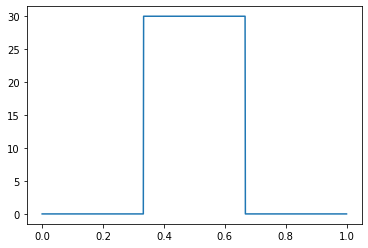

In [14]:
def f1(x):
    '''
    #Potential function in the finite square well.
    '''
    y=[]
    for i in range(N):
        if 1/3 <= x[i] <=2/3:
            val = 30
        elif x[i]<0:
            val=500
        elif x[i]>1:
            val=500
        else:
            val = 0
        y.append(val)
    return y
plt.plot(x,f1(x))
print(len(f1(x)),N)

In [15]:
potential = {
    "x_low": 0.0,
    "x_high": 1.0,
    "delta": 1/N,
    "V": f1(x)
}

# potential1 = {
#     "x_low": 0.0,
#     "x_high": 1.0,
#     "delta": 1/N,
#     "V": f
# }

#integrate(E = 1, **infinite_well)[1000]
#integrate(E = 7, **potential)

In [16]:
def find_energy(potential):
    def find_energy_high(potential):
        for i in range(3000):
            if integrate(E = i/10, **potential)[N - 2] > 0:
                return i/10
    def find_energy_low(potential):
        for i in range(3000):
            if integrate(E = i/10, **potential)[N - 2] < 0:
                return i/10

    E_high0 = find_energy_high(potential)
    E_low0 = find_energy_low(potential)
#     print(E_high0)
#     print(E_low0)
    if E_high0 > E_low0:
        E_high=E_high0
        for i in range(300):
            if integrate(E = E_high0-i/10, **potential)[N-2] < 0:
                E_low = E_high0-i/10
                return E_high, E_low
    if E_low0 > E_high0:
        E_low=E_low0
        for i in range(300):
            if integrate(E = E_low0-i/10, **potential)[N-2] > 0:
                E_high = E_low0-i/10
                return E_high, E_low

In [17]:
def deviation(psi_computed, psi_actual):
    return psi_computed - psi_actual

def find_energy_eigenstate(E_low, E_high, integration_params, show_plots = False):
    psi_right = 0.0

    psi_low = integrate(E_low, **integration_params, plot=False)
    psi_high = integrate(E_high, **integration_params, plot=False)
    dev_low = deviation(psi_low[-1], psi_right)
    dev_high = deviation(psi_high[-1], psi_right)

    def helper(low, high, d_low, d_high):
        E_mid = (low + high) / 2.0
        psi_mid = integrate(E_mid, **integration_params, plot=False)
        if (high - low) < 1e-8:
            return E_mid, [psi_mid]

        d_mid = deviation(psi_mid[-1], psi_right)
        if (d_low * d_mid) < 0.0:
            E_approx, psis = helper(low, E_mid, d_low, d_mid)
        else:
            E_approx, psis = helper(E_mid, high, d_mid, d_high)

        psis = [psi_mid] + psis
        return E_approx, psis

    E_approx, psis = helper(E_low, E_high, dev_low, dev_high)
    psis = [psi_low, psi_high] + psis
#     print("num iterations =", len(psis))

    xs = [integration_params["x_low"] + i * integration_params["delta"] for i in range(len(psis[-1]))]
    if show_plots == True:
        for i in range(len(psis)):
            plt.plot(xs, psis[i])
            plt.grid()
        plt.show()

        plt.plot(xs, psis[-1])
        plt.grid()
        plt.show()

    return E_approx, psis[-1]

In [18]:
print(find_energy(potential))
E_approx, psi = find_energy_eigenstate(find_energy(potential)[1], find_energy(potential)[0], integration_params=potential)
E_approx, psi1 = find_energy_eigenstate(find_energy(potential1)[1], find_energy(potential1)[0], integration_params=potential1)

(18.799999999999997, 18.9)


NameError: name 'potential1' is not defined

In [ ]:
x1 = np.linspace(0,1,N-1)
plt.plot(x1, psi1)

In [62]:
def generate_pot_psi_pairs(num,N=1000):
    '''
    generates potential, wavefunction pairs
    
    Args:
        num: number of labeled data pieces to make
    
    Kwargs:
        N: length of potential & wavefunction vectors (1000 is nice)
    
    '''
    pot_set = np.zeros((num,N))
    psi_set = np.zeros((num,N))
    en_set = np.zeros((num,1)) 
    
    
    for n in range(num):
        partial_pot = generate_pot()
        full_pot = {
                    "x_low": 0.0,
                    "x_high": 1.0,
                    "delta": 1/N,
                    "V": partial_pot
        }
        

        E_approx, psi = find_energy_eigenstate(find_energy(full_pot)[1], 
                                               find_energy(full_pot,)[0], 
                                               integration_params=full_pot,
                                               show_plots = False
                                              )
        psi_long = np.append(psi,np.array([0]),0)
#         #plt.plot(partial_pot,psi_long)
#         xs = np.arange(0,1.,1/N)
#         plt.plot(xs,partial_pot)
#         plt.show()
#         plt.plot(xs,psi_long)
#         plt.show()

        if n%10==0:
            print(f'{n} of {num} done.')
    
    
#         data_set.append((full_pot['V'],psi_long,E_approx))
        pot_set[n,:] = full_pot['V']
        psi_set[n,:] = psi_long
        en_set[n,:] = E_approx
    print('Totally done.')
    return pot_set,psi_set,en_set

pot_set,psi_set,en_set = generate_pot_psi_pairs(1000)


# print(np.shape(pot_set))
# print(pot_set)

0 of 1000 done.
10 of 1000 done.
20 of 1000 done.
30 of 1000 done.
40 of 1000 done.
50 of 1000 done.
60 of 1000 done.
70 of 1000 done.
80 of 1000 done.
90 of 1000 done.
100 of 1000 done.
110 of 1000 done.
120 of 1000 done.
130 of 1000 done.
140 of 1000 done.
150 of 1000 done.
160 of 1000 done.
170 of 1000 done.
180 of 1000 done.
190 of 1000 done.
200 of 1000 done.
210 of 1000 done.
220 of 1000 done.
230 of 1000 done.
240 of 1000 done.
250 of 1000 done.
260 of 1000 done.
270 of 1000 done.
280 of 1000 done.
290 of 1000 done.
300 of 1000 done.
310 of 1000 done.
320 of 1000 done.
330 of 1000 done.
340 of 1000 done.
350 of 1000 done.
360 of 1000 done.
370 of 1000 done.
380 of 1000 done.
390 of 1000 done.
400 of 1000 done.
410 of 1000 done.
420 of 1000 done.
430 of 1000 done.
440 of 1000 done.
450 of 1000 done.
460 of 1000 done.
470 of 1000 done.
480 of 1000 done.
490 of 1000 done.
500 of 1000 done.
510 of 1000 done.
520 of 1000 done.
530 of 1000 done.
540 of 1000 done.
550 of 1000 done.
560

In [56]:
# print(np.shape(pot_set))
# print(np.shape(psi_set))
# print(psi_set)
# print(en_set)

(2, 1000)
(2, 1000)
[[ 0.00000000e+00  1.10660721e-02  2.21311915e-02 ... -8.62286493e-03
   4.13792537e-10  0.00000000e+00]
 [ 0.00000000e+00  9.84849975e-03  1.96970089e-02 ... -4.69554193e-03
  -8.79133412e-11  0.00000000e+00]]
[[ 9.08456202]
 [16.38373506]]


In [63]:
# save data. Be careful about overwriting!!
# with h5py.File('schro_data.hdf5','w') as f:
#     dset0 = f.create_dataset(f"pot_data",data=pot_set)
#     dset1 = f.create_dataset(f"psi_data",data=psi_set)
#     dset2 = f.create_dataset(f"en_data",data=en_set)


In [61]:
with h5py.File('schro_data.hdf5','r') as f:
    pot = np.array(f['pot_data'])
    psi = np.array(f['psi_data'])
    en = np.array(f['en_data'])
#     print(psi)
    print(np.shape(psi))
    print(np.shape(en_set))

(500, 1000)
(500, 1)


In [26]:
# # save wavefunctions
# with open('wavefunctions.txt', 'w') as f:
#     for item in data_points:
#         f.write(str([i for i in item[1]]).strip('[]') + '\n')

In [ ]:
# with open('potential.txt', 'w') as f:
#     for item in data_points:
#         f.write(str([i for i in item[0]['V']]).strip('[]') + '\n')

In [ ]:
psif=[]
for i in range(N-1):
    psif.append(psi[i]-psi1[i])
plt.plot(np.linspace(0,1,N-1),psif)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation

In [ ]:
psi = []
psi.append(0.0)
psi.append(0.1)
for i in range(2, N-1):
   # x_next = i * delta
    #x = x_next - delta
    #x_prev = x - delta
    x = i
    x_next = i + 1
    x_prev = i - 1

    denominator = 1.0 - delta_sq * f[x_next]
    c1 = (2.0 - delta_sq * f[x]) / denominator
    c2 = (1.0 - delta_sq * f[x_prev]) / denominator

    #psi[i] = c1 * psi[i-1] - c2 * psi[i - 2]
    psi_new = c1 * psi[i-1] - c2 * psi[i - 2]
    psi.append(psi_new)

print(len(psi))

In [ ]:
infinite_well = {
    "x_low": -1.0,
    "x_high": 1.0,
    "delta": 0.002,
    "V": lambda x: 0.0
    #"V": f
}

In [ ]:
for i in range(2, 3):
       # x_next = i * delta
        #x = x_next - delta
        #x_prev = x - delta
        delta_sq = (1/N)**2
        x = i
        x_next = i + 1
        x_prev = i - 1
        denominator = 1.0 - delta_sq * f[x_next]
        c1 = (2.0 - delta_sq * f[x]) / denominator
        c2 = (1.0 - delta_sq * f[x_prev]) / denominator

        psi[i] = c1 * psi[i-1] - c2 * psi[i - 2]
        psi[i] = c1 * psi[i-1] - c2 * psi[i - 2]
        print(c1,c2)

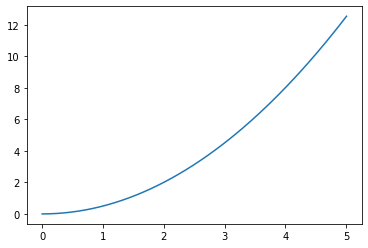

In [8]:
N = 128
x = np.linspace(0,5+1/N,N)
f = x ** 2 / 2
plt.plot(x,f)

In [ ]:
def find_energy_high(potential):
        for i in range(300):
            if integrate(E = 3+i/10, **potential)[N - 2] > 0:
                return i/10
def find_energy_low(potential):
    for i in range(300):
        if integrate(E =  3+i/10, **potential)[N - 2] < 0:
            return i/10
f = [0]*128
E_high0 = find_energy_high(potential)
E_low0 = find_energy_low(potential)
print(E_high0, E_low0)
      
if E_high0 > E_low0:
    E_high=E_high0
    for i in range(300):
        if integrate(E = E_high0-i/10, **potential)[N-2] < 0:
            E_low = E_high0-i/10
    print(E_high, E_low) 
if E_low0 > E_high0:
    E_low=E_low0
    for i in range(300):
        if integrate(E = E_low0-i/10, **potential)[N-2] > 0:
            E_high = E_low0-i/10
    print(E_high, E_low) 